In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.tools.visualization import plot_histogram

In [2]:
## oracle_initialize_part

def OR(qubit_1, qubit_2, k):
    # enter qubit numbers here 
    """ function does the equivalent of a classical OR between qubit numbers a and b and stores the result in qubit number k """
#     qc.barrier(q)
    qc.x(q[qubit_1])
    qc.x(q[qubit_2])
#     qc.barrier(q)
    qc.ccx(q[qubit_1], q[qubit_2], q[k])
    qc.x(q[k])
#     qc.barrier(q)
    qc.x(q[qubit_1])
    qc.x(q[qubit_2])
#     qc.barrier(q)
    

def are_not_equal(a_0, b_0, k):
    # enter node numbers here. For example, a is node 0, b is node 1 and c is node 2
    """ function outputs 1 if nodes a and b are not the same. Node numbering starts from 0
        as in the problem statement. k is the qubit number where the output is XOR-ed. qubit
        numbering also starts from 0 """
#     qc.barrier(q)
    qc.cx(q[2*a_0], q[2*b_0])
    qc.cx(q[(2*a_0) + 1], q[(2*b_0) + 1])
    OR(2*b_0, (2*b_0)+1, k)
    qc.cx(q[2*a_0], q[2*b_0])
    qc.cx(q[(2*a_0) + 1], q[(2*b_0) + 1])
#     qc.barrier(q)

def is_not_3(a, k):
    qc.ccx(q[2*a], q[(2*a)+1], q[k])
    qc.x(q[k])
    
def initialize_oracle_part(n):
    t = 4
#     qc.barrier(q)
    are_not_equal(0, 1, 6) # node a and b are not equal 
    are_not_equal(0, 2, 7)
    are_not_equal(1, 2, 8)
    is_not_3(0, 11)
    is_not_3(1, 12)
    is_not_3(2, 13)
#     qc.barrier(q)
    qc.mct([q[6], q[7], q[8], q[11], q[12], q[13]], q[10],[q[9], q[14], q[15], q[16]]) # answer is stored in 10. please keep 9 a clean qubit, it's used as ancilla here 
#     qc.barrier(q)
    is_not_3(0, 11)
    is_not_3(1, 12)
    is_not_3(2, 13)
    are_not_equal(0, 1, 6) # node a and b are not equal 
    are_not_equal(0, 2, 7)
    are_not_equal(1, 2, 8)

In [3]:
## distance_black_box

distances = {
    "32": 3,
    "31": 2,
    "30": 4,
    "21": 7,
    "20": 6,
    "10": 5,
}

def dist_single():
    qr = QuantumRegister(2)
    qr_target = QuantumRegister(5)
    qc = QuantumCircuit(qr, qr_target, name='dist_single')
    
    for edge in distances:
        if edge[0] == '3':
            node = format(int(edge[1]), '02b')
            d_bin = format(distances[edge], '02b')
            
            for idx in range(len(node)):
                if node[idx] == '0':
                    qc.x(qr[idx])
            
            for idx in range(len(d_bin)):
                if d_bin[idx] == '1':
                    qc.ccx(qr[0], qr[1], qr_target[idx])
            
            for idx in range(len(node)):
                if node[idx] == '0':
                    qc.x(qr[idx])
    
    return qc

def dist():
    qr1 = QuantumRegister(2)
    qr2 = QuantumRegister(2)
    qr_target = QuantumRegister(5)
    qr_anc = QuantumRegister(2)
    qc = QuantumCircuit(qr1, qr2, qr_target, qr_anc, name='dist')
    
    for edge in distances:
        if edge[0] != '3':
            # convert to binaries
            node1 = format(int(edge[0]), '02b')
            node2 = format(int(edge[1]), '02b')
            d_bin = format(distances[edge], '02b')

            for idx in range(len(node1)): # assume node1 and node2 have the same length
                if node1[idx] == '0':
                    qc.x(qr1[idx])
                    
            for idx in range(len(node2)):
                if node2[idx] == '0':
                    qc.x(qr2[idx])

            for idx in range(len(d_bin)):
                if d_bin[idx] == '1':
                    qc.mct(qr1[:]+qr2[:], qr_target[idx], qr_anc)
                    
            for idx in range(len(node2)): # invert back
                if node2[idx] == '0':
                    qc.x(qr2[idx])

            for idx in range(len(node1)):
                if node1[idx] == '0':
                    qc.x(qr1[idx])
                
    return qc

In [4]:
## multi_adder_1

def maj(a, b, k):
    qc.cx(q[k], q[b])
    qc.cx(q[k], q[a])
    qc.ccx(q[a], q[b], q[k])
    
def unmaj(a, b, k):
    qc.ccx(q[a], q[b], q[k])
    qc.cx(q[k], q[a])
    qc.cx(q[a], q[b])
    
def multiple_adder(a, b, c_0, z):
    arr_size = len(a)
    maj(c_0, b[0], a[0])
    for i in range(arr_size-1):
        maj(a[i], b[i+1], a[i+1])
    qc.cx(q[a[arr_size-1]], q[z])
    for i in reversed(range(arr_size-1)):
        unmaj(a[i], b[i+1], a[i+1])
    unmaj(c_0, b[0], a[0])

In [5]:
## diffusion
def diffusion():
    qc.h(q[0:6])
    qc.x(q[0:6])
    qc.h(q[5])
    qc.barrier()
    qc.mct(q[0:5], q[5], q[7:10])
    qc.barrier()
    qc.h(q[5])
    qc.x(q[0:6])
    qc.h(q[0:6])

In [11]:
qubit_num = 25  # max is 32 if you're using the simulator

# Ancilla indices
inputs = [0, 1, 2, 3, 4, 5]
init_ancillae = [6, 7, 8, 9]
valid = [10]
temp_dist = [11, 12, 13, 14, 15]
total_dist = [16, 17, 18, 19, 20]
gate_ancillae = [21, 22, 23]
check_dist = [11, 12, 13, 14, 15] # initialize 13 here
carry_check = [24]

inputs = inputs[0]
init_ancillae = init_ancillae[0]
valid = valid[0]
temp_dist = temp_dist[0]
total_dist = total_dist[0]
gate_ancillae = gate_ancillae[0]
check_dist = check_dist[0]
carry_check = carry_check[0]

q = QuantumRegister(qubit_num)
c = ClassicalRegister(6)
qc = QuantumCircuit(q, c)

qc.h(q[0:6])
qc.x(q[carry_check])

# forward oracle
initialize_oracle_part(4)
qc.append(dist_single(), q[inputs:inputs+2] + q[temp_dist:temp_dist+5])
multiple_adder([11, 12, 13, 14], [16, 17, 18, 19], init_ancillae, 20)
qc.append(dist_single().inverse(), q[inputs:inputs+2] + q[temp_dist:temp_dist+5])
qc.append(dist(), q[inputs:inputs+4] + q[temp_dist:temp_dist+5] + q[gate_ancillae:gate_ancillae+2])
multiple_adder([11, 12, 13, 14], [16, 17, 18, 19], init_ancillae, 20)
qc.append(dist().inverse(), q[inputs:inputs+4] + q[temp_dist:temp_dist+5] + q[gate_ancillae:gate_ancillae+2])
qc.append(dist(), q[inputs+2:inputs+6] + q[temp_dist:temp_dist+5] + q[gate_ancillae:gate_ancillae+2])
multiple_adder([11, 12, 13, 14], [16, 17, 18, 19], init_ancillae, 20)
qc.append(dist().inverse(), q[inputs+2:inputs+6] + q[temp_dist:temp_dist+5] + q[gate_ancillae:gate_ancillae+2])
qc.x(q[check_dist:check_dist+3]) # init 15
multiple_adder([11, 12, 13, 14, 15], [16, 17, 18, 19, 20], init_ancillae, carry_check)

# carry_check
# qc.barrier()
qc.cz(q[valid], q[carry_check])
# qc.barrier()

# inverse oracle
multiple_adder([11, 12, 13, 14, 15], [16, 17, 18, 19, 20], init_ancillae, carry_check)
qc.x(q[check_dist:check_dist+3]) # init 15
qc.append(dist().inverse(), q[inputs+2:inputs+6] + q[temp_dist:temp_dist+5] + q[gate_ancillae:gate_ancillae+2])
multiple_adder([11, 12, 13, 14], [16, 17, 18, 19], init_ancillae, 20)
qc.append(dist(), q[inputs+2:inputs+6] + q[temp_dist:temp_dist+5] + q[gate_ancillae:gate_ancillae+2])
qc.append(dist().inverse(), q[inputs:inputs+4] + q[temp_dist:temp_dist+5] + q[gate_ancillae:gate_ancillae+2])
multiple_adder([11, 12, 13, 14], [16, 17, 18, 19], init_ancillae, 20)
qc.append(dist(), q[inputs:inputs+4] + q[temp_dist:temp_dist+5] + q[gate_ancillae:gate_ancillae+2])
qc.append(dist_single().inverse(), q[inputs:inputs+2] + q[temp_dist:temp_dist+5])
multiple_adder([11, 12, 13, 14], [16, 17, 18, 19], init_ancillae, 20)
qc.append(dist_single(), q[inputs:inputs+2] + q[temp_dist:temp_dist+5])
initialize_oracle_part(4)

diffusion()

qc.measure(q[:6], c)
# qc.draw()

In [12]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc)
print(new_circuit.count_ops())

OrderedDict([('u3', 3252), ('cx', 1933), ('measure', 6), ('barrier', 2)])


In [13]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
counts = job.result().get_counts()

In [14]:
print(sorted(counts.items(), key=lambda x:x[1], reverse=True)[0:20])

[('011000', 54), ('100001', 38), ('001001', 35), ('111101', 33), ('001011', 31), ('010010', 29), ('000110', 28), ('111001', 27), ('000100', 27), ('100110', 25), ('101001', 24), ('001101', 23), ('101101', 23), ('000001', 22), ('011111', 21), ('011101', 21), ('100111', 20), ('001010', 20), ('100010', 20), ('000101', 20)]


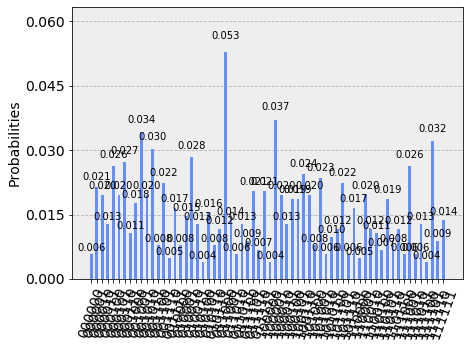

In [15]:
plot_histogram(counts)